In [1]:
import jax
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import vmap, grad, jit
from jax.scipy.special import sph_harm

import s2fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt




def colormap(x):
    cmap = plt.get_cmap('viridis', 256)
    return cmap(x)


def normalize(v, vmin=None, vmax=None):
    if vmin is None:
        vmin = jnp.min(v)
    if vmax is None:
        vmax = jnp.max(v)
    return (v - vmin) / (vmax - vmin)

@jit
def ifft_shifted(f):
    return jnp.fft.ifft(jnp.fft.ifftshift(f)) * len(f)
    
@jit
def fft_shifted(f):
    return jnp.fft.fftshift(jnp.fft.fft(f))

  
def rotY(beta):
    return jnp.array([
        [jnp.cos(beta), 0, jnp.sin(beta)],
        [0, 1, 0],
        [-jnp.sin(beta), 0, jnp.cos(beta)]
    ])


def rotZ(gamma):
    return jnp.array([
        [jnp.cos(gamma), -jnp.sin(gamma), 0],
        [jnp.sin(gamma), jnp.cos(gamma), 0],
        [0, 0, 1]
    ])
    

def rotZYZ(alpha, beta, gamma):
    return rotZ(alpha) @ rotY(beta) @ rotZ(gamma)

@jit
def cart2sph(x, y, z):
    r = jnp.sqrt(x**2 + y**2 + z**2)
    theta = jnp.arccos(z/r)
    phi = jnp.arctan2(y, x)
    return theta, phi

@jit
def sph2cart(theta, phi, r=1.):
    x = r * jnp.sin(theta) * jnp.cos(phi)
    y = r * jnp.sin(theta) * jnp.sin(phi)
    z = r * jnp.cos(theta)
    return x, y, z

@jit
def rot_sph(theta, phi, alpha, beta, gamma):
    x, y, z = sph2cart(theta, phi)
    x, y, z = rot_pt(x, y, z, alpha, beta, gamma)
    return cart2sph(x, y, z)

@jit
def rot_pt(x, y, z, alpha, beta, gamma):
    R = rotZYZ(alpha, beta, gamma)
    xyz = (R @ jnp.array([[x, y, z]]).T).squeeze()
    return xyz[0], xyz[1], xyz[2]

@jit
def rot_pts(x,y,z, alpha, beta, gamma):
    R = rotZYZ(alpha, beta, gamma)
    xyz = vmap(lambda xi,yi,zi: R @ jnp.array([[xi, yi, zi]]).T)(x, y, z)
    return xyz[:,0], xyz[:,1], xyz[:,2]


@jit
def inv_rot_pts(x,y,z, alpha, beta, gamma):
    return rot_pts(x, y, z, -gamma, -beta, -alpha)

@jit
def inv_rot_pt(x,y,z,alpha, beta, gamma):
    return rot_pt(x, y, z, -gamma, -beta, -alpha)


def eval_shell(theta, phi, fm, ls, ms, L_max):
    # sph_harm uses different conventions for theta and phi
    theta, phi = phi, theta
    return jnp.sum(sph_harm(ms, ls, jnp.array([theta]), jnp.array([phi]), n_max=L_max) * fm)
    #return jnp.sum(basis(ms) * fm)

@jit
def rot_sph_harm(fm, alpha, d_beta, gamma, ms):
    return jnp.exp(-1j*ms*alpha) * jnp.einsum('ij,j->i', d_beta, jnp.exp(-1j*ms*gamma) * fm)

@jit
def rot_slice_sph(fm, alpha, d_beta, gamma, ms, sph_zero):
    return rot_sph_harm(fm, alpha, d_beta, gamma, ms) * sph_zero


def get_slicing_weights(betas, ms, L):
    d_beta = vmap(lambda beta: s2fft.utils.rotation.generate_rotate_dls(L, beta)[-1, :, :])(betas)
    sph_zero = sph_harm(ms, jnp.ones_like(ms)*(L-1), 0., jnp.pi/2)
    return d_beta, sph_zero


def random_signal(L, key):
    key1, key2 = jax.random.split(key)
    ms = jnp.arange(-(L-1), (L-1)+1).astype(jnp.int32)
    f = jax.random.normal(key1, (2*L-1,)) + jax.random.normal(key2, (2*L-1,)) * 1j
    f = f + (-1)**(L-1-ms)*jnp.conjugate(f[::-1])
    return f

def sample_on_sphere(key, N):
    return cart2sph(*jax.random.normal(key, (3, N)))
    

def random_so3(key, N):
    Alphas, Betas = sample_on_sphere(key, N)
    Gammas = jax.random.uniform(key, (N,)) * 2 * jnp.pi
    return Alphas, Betas, Gammas

@jit
def get_corr(afft, bfft):
    return ifft_shifted(afft * jnp.conjugate(bfft))

@jit
def max_corr(afft, bfft):
    corr = get_corr(afft, bfft).real/ jnp.linalg.norm(afft) / jnp.linalg.norm(bfft)
    argmax = jnp.argmax(corr)
    return corr[argmax], argmax

@jit
def max_corr_slices(afft_vec, bfft):
    corr_max, arg_max = vmap(max_corr, (0, None))(afft_vec, bfft)
    meta_argmax = jnp.argmax(corr_max)
    return arg_max[meta_argmax], meta_argmax

@jit
def align_data_to_slices(fm_rot_slices, data, fft_data):
    arg_max, meta_argmax = max_corr_slices(fm_rot_slices, fft_data)
    return jnp.roll(data, arg_max), meta_argmax

@jit
def align_data_to_slices_average(fm_rot_slices, data, fft_data):
    vmap_aligns = vmap(align_data_to_slices, (None, 0, 0))
    aligned_data, slice_idx = vmap_aligns(fm_rot_slices, data, fft_data)
    conditional_mean = lambda idx: jnp.sum(jnp.where(slice_idx[:, None] == idx, aligned_data, jnp.zeros_like(aligned_data)), axis=0)/jnp.sum(slice_idx == idx)
    return vmap(conditional_mean)(jnp.arange(fm_rot_slices.shape[0]))
    


def plot_sph_parity(f, thetas, phis):
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Re F(r)")
    v = colormap(normalize(f.real))
    plot_sph(v, thetas, phis, ax)
    
    ax = plt.subplot(142, projection='3d')
    plt.title("Re F(-r)")
    v = colormap(normalize(f.real))
    plot_sph(v, jnp.pi - thetas, phis + jnp.pi, ax)

    ax = plt.subplot(143, projection='3d')
    plt.title("Im F(r)")
    v = colormap(normalize(f.imag))
    plot_sph(v, thetas, phis, ax)

    ax = plt.subplot(144, projection='3d')
    plt.title("-Im F(-r)")
    v = colormap(normalize(-f.imag))
    plot_sph(v, jnp.pi - thetas, phis + jnp.pi, ax)
    

def plot_sph(f, theta, phi, ax):
    theta, phi = jnp.meshgrid(theta, phi)
    x, y, z = sph2cart(theta, phi)
    ax.plot_surface(x, y, z, facecolors=f, rstride=1, cstride=1, shade=False)


def plot_rot(alphas, betas, N):
    gammas = jnp.zeros_like(alphas)
    t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]
    x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
    i1, i2 = 0, 5
    
    # Plot sampling points
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Sampled angles")
    ax.scatter(*sph2cart(betas, alphas, r=1), color='r')
    
    # Scatter rotated pooints for alpha[i], beta[i] rotation
    ax = plt.subplot(142, projection='3d')
    plt.title("Example rotation 1")
    ax.scatter(*rot_pts(x0, y0, z0, alphas[i1], betas[i1], gammas[i1]), color='r')
    ax.plot(*[[0., p] for p in rot_pt(0, 0, 1., alphas[i1], betas[i1], gammas[i1])], color='b')
    
    ax = plt.subplot(143, projection='3d')
    plt.title("Example rotation 2")
    ax.scatter(*rot_pts(x0, y0, z0, alphas[i2], betas[i2], gammas[i2]), color='r')
    ax.plot(*[[0., p] for p in rot_pt(0, 0, 1., alphas[i2], betas[i2], gammas[i2])], color='b')
    
    ax = plt.subplot(144, projection='3d')
    plt.title("Coverage")
    for i in range(len(alphas)):
        ax.scatter(*rot_pts(x0, y0, z0, alphas[i], betas[i], gammas[i]), color='b')
    ax.scatter(*sph2cart(betas, alphas, r=1), color='r')
    ax.view_init(elev=0, azim=90)



## Define Discretization

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


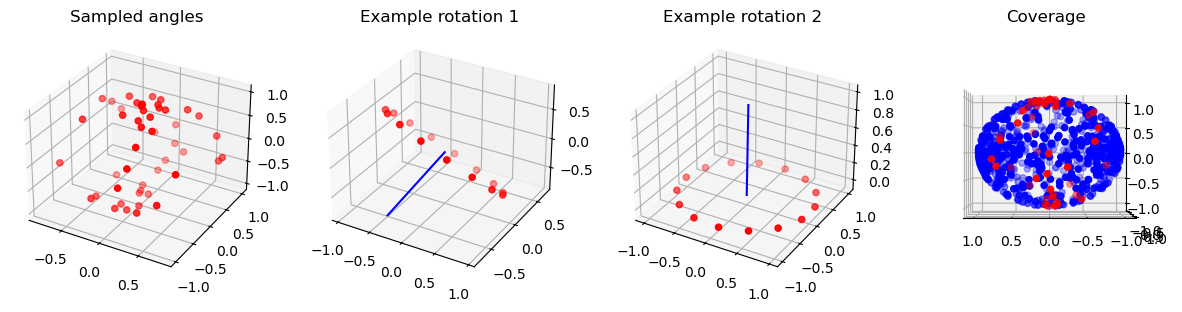

In [2]:
base_key = jax.random.PRNGKey(0)

# Indices
L = 8
ms = jnp.arange(-(L-1), (L-1)+1)#.astype(jnp.int32)
ls = jnp.ones_like(ms)*(L-1)
eval_shell_wrap = lambda thetas, phis, fm: eval_shell(thetas, phis, fm, ls, ms, L)

# Eval grid
thetas = jnp.linspace(0, jnp.pi, 50)
phis = jnp.linspace(0, 2*jnp.pi, 101)#[:-1]

# Interpolation grid
sampling_interp = "mw"
phis_interp = s2fft.sampling.s2_samples.phis_equiang(L, sampling_interp)
thetas_interp = s2fft.sampling.s2_samples.thetas(L, sampling_interp)

# Signal
base_key, key = jax.random.split(base_key)
fm = random_signal(L, key)
f = vmap(vmap(lambda theta, phi: eval_shell(theta, phi, fm, ls, ms, L), (0, None)), (None, 0))(thetas, phis)

# Alphas, betas (rotation angles to align)
sampling = "rnd" # "mw"
if sampling == "mw":
    Lmax = L
    alphas = s2fft.sampling.s2_samples.phis_equiang(Lmax, sampling)
    betas = s2fft.sampling.s2_samples.thetas(Lmax, sampling)
    Alphas, Betas = jnp.meshgrid(alphas, betas)
    Alphas, Betas = Alphas.flatten(), Betas.flatten()
elif sampling == "rnd":
    Nrots = 50
    base_key, key = jax.random.split(base_key)
    Alphas, Betas = sample_on_sphere(key, Nrots)

Gammas = jnp.zeros_like(Alphas)
d_betas, sph_zero = get_slicing_weights(Betas, ms, L)
fm_rot_slices = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas, d_betas, Gammas, ms, sph_zero)
plot_rot(Alphas, Betas, (2*L-1))

## Generate Data

In [3]:
# Random data
Ndata = 1000
sigma = 0.00
base_key, key = jax.random.split(base_key)
Alpha_data, Beta_data, Gamma_data = random_so3(key, Ndata)
d_beta_data, sph_zeros = get_slicing_weights(Beta_data, ms, L)
data_slices = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alpha_data, d_beta_data, Gamma_data, ms, sph_zeros)

base_key, key1, key2 = jax.random.split(base_key, 3)
noise = jax.random.normal(key1, data_slices.shape) + 1j * jax.random.normal(key2, data_slices.shape)
noise = noise + (-1)**(ms) * jnp.conjugate(noise[:,::-1])

noisy_data_slices = data_slices + noise * sigma
noisy_data_slices_ifft = vmap(ifft_shifted)(noisy_data_slices)

snr = jnp.linalg.norm(data_slices)/jnp.linalg.norm(noise*sigma)
print(f"SNR: {snr}")

SNR: inf


## Interpolate to grid 

In [4]:
def lu_kernel(x_data, kernel):
    K = vmap(vmap(kernel, (0, None)), (None, 0))(x_data, x_data)
    lu_sol = jax.scipy.linalg.lu_factor((K + jnp.eye(K.shape[0])*0.01).astype(jnp.complex128))
    return lu_sol

def sph_regressor(x_data, y_data, lu_sol):
    weights = jax.scipy.linalg.lu_solve(lu_sol, y_data)
    regressor = lambda theta, phi: jnp.sum(vmap(kernel, (None, 0))(jnp.array(sph2cart(theta, phi)), x_data) * weights)
    return regressor


fft_precomp = s2fft.generate_precomputes_jax(L, sampling="mw")

t = jnp.linspace(0, 2*jnp.pi, len(fm_rot_slices[0])+1)[:-1]
x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
XYZ = jnp.array(vmap(inv_rot_pts, (None, None, None, 0, 0, 0))(x0, y0, z0, Alphas, Betas, Gammas))
XYZ_flat = XYZ.reshape(3,-1).T


kernel = lambda x, y: jnp.exp(-jnp.linalg.norm(x-y)**2 / (0.9/L))
lu_sol = lu_kernel(XYZ_flat, kernel)


N_align = 500
fm_template0 = random_signal(L, key) # fm_rot_slices
fm_template = fm_template0
for i in range(N_align):
    fm_rot_template = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm_template, Alphas, d_betas, Gammas, ms, sph_zero)
    f_aligned = align_data_to_slices_average(fm_rot_template, noisy_data_slices_ifft, noisy_data_slices)
    f_aligned = jnp.where(jnp.isnan(f_aligned), 0., f_aligned)
    
    
    regressor = sph_regressor(XYZ_flat, f_aligned.reshape(-1), lu_sol)
    f_aligned_interp = vmap(vmap(regressor, (0, None)), (None, 0))(thetas_interp, phis_interp).T
    fm_aligned_interp = s2fft.forward_jax(f_aligned_interp, L, sampling="mw")[-1,:]#, precomps=fft_precomp)[-1, :]
    #fm_aligned_interp = 
    fm_template = fm_aligned_interp
    #print(fm_template.shape, fm_aligned_interp.shape)

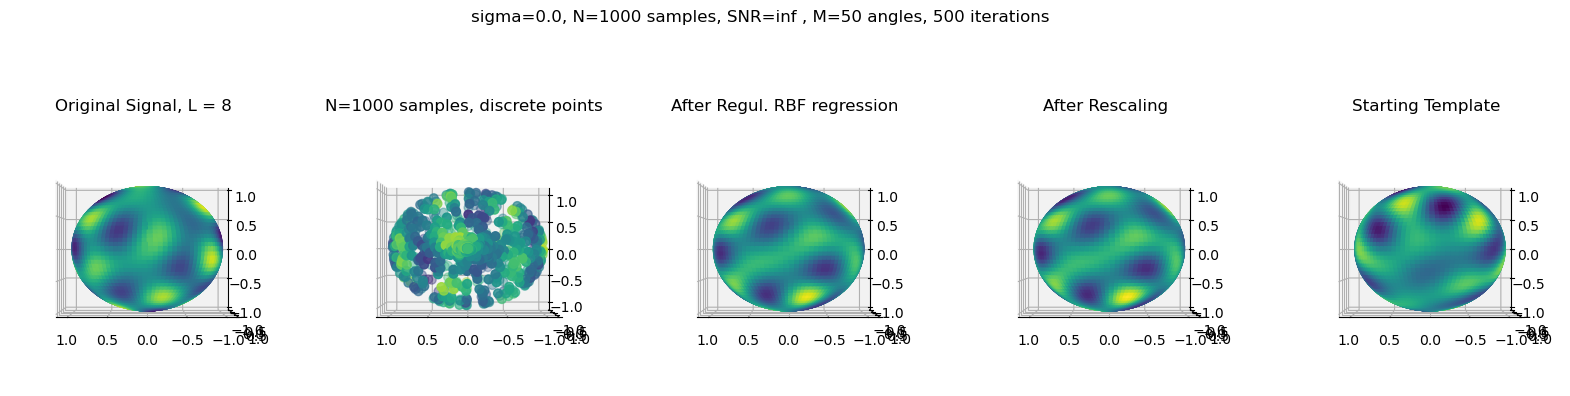

In [5]:


def rigid_body_align(fm, fm_template, ms, L, Alphas, Betas, Gammas):
    d_betas, _ = get_slicing_weights(Betas, ms, L)
    fm_template_rot = vmap(rot_sph_harm, (None, 0, 0, 0, None))(fm_template, Alphas, d_betas, Gammas, ms)
    argmax = jnp.argmax(vmap(lambda a,b: jnp.sum(a * jnp.conjugate(b)).real, (0, None))(fm_template_rot, fm))
    return  fm_template_rot[argmax]

fm_template = rigid_body_align(fm, fm_template, ms, L, Alpha_data, Beta_data, Gamma_data)
f_template0 = rigid_body_align(fm, fm_template0, ms, L, Alpha_data, Beta_data, Gamma_data)
#f_aligned_interp = vmap(vmap(regressor, (0, None)), (None, 0))(thetas, phis)

f_tmpl = vmap(vmap(lambda theta, phi: eval_shell(theta, phi, fm_template0, ls, ms, L), (0, None)), (None, 0))(thetas, phis)
f_aligned_interp = vmap(vmap(lambda theta, phi: eval_shell(theta, phi, fm_template, ls, ms, L), (0, None)), (None, 0))(thetas, phis)

if L % 2 == 0:
    ftrue = f.imag
    fdata = f_aligned.reshape(-1).imag
    finterp = f_aligned_interp.imag
    ftmpl = f_tmpl.imag
else:
    ftrue = f.real
    fdata = f_aligned.reshape(-1).real
    finterp = f_aligned_interp.real
    ftmpl = f_tmpl.real

plt.figure(figsize=(20, 5))
plt.suptitle(f"sigma={sigma}, N={Ndata} samples, SNR={snr:.2f} , M={Nrots} angles, {N_align} iterations")

ax1 = plt.subplot(151, projection='3d')
v = colormap(normalize(ftrue))
vmax, vmin = jnp.max(ftrue), jnp.min(ftrue)
plot_sph(v, thetas, phis, ax1)
plt.title(f"Original Signal, L = {L}")

ax2 = plt.subplot(152, projection='3d')
v = colormap(normalize(fdata, vmin, vmax))
ax2.scatter(*XYZ_flat.T, s=40, color=v)
plt.title(f"N={Ndata} samples, discrete points")
    
ax3 = plt.subplot(153, projection='3d')
v = colormap(normalize(finterp, vmin, vmax))
plot_sph(v, thetas, phis, ax3)
plt.title(f"After Regul. RBF regression")

ax4 = plt.subplot(154, projection='3d')
v = colormap(normalize(finterp))
plot_sph(v, thetas, phis, ax4)
plt.title(f"After Rescaling")

ax5 = plt.subplot(155, projection='3d')
v = colormap(normalize(ftmpl))
plot_sph(v, thetas, phis, ax5)
plt.title(f"Starting Template")


elev, azim = 0, 90
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.view_init(elev=elev, azim=azim)

In [ ]:
# 

# Partition of unity from Fredrik
# There are ways to choose a smarter partition of unity
# Nufft + expanding the thetas, phis 
# RBF regression + sparsification
# Sounds reasonable to go local



## Idea:
## Instead of approximating the discrete angles, we run clustering on the angles,
## And then find the optimal rotation for each cluster. This should be more stable, and can handle non-uniform sampling better.


#
# Angle recovery
#   # Step 0: Precompute Wigner-D matrices and Great Circle Fourier Coefficients
        # Step 0a: Precompute Wigner-D matrices
            # wigner_D = vmap(s2fft.recursion_etc)(alphas, betas)
        # Step 0b: Precompute Great Circle Fourier Coefficients
    # Step 1: Iterate over alpha, beta
        # Step 1a: compute optimal plane rot phi, and correlation c
        # phi_max, corr_max = vmap(lambda alpha, beta: opt_rot(alpha, beta, fm, data))(alphas, betas)
            # step 1aa: rotate fm by alpha, beta using wigner-D (PRECOMPUTE: step 0)
            # step 1ab: extract fourier coefficients of rotated signal at great circle (PRECOMPUTE: step 0)
            # step 1ac: compute correlation between rotated signal and data
            # corr(afft,bfft) = ifft(afft*conj(bfft))
            # cval = corr(data_fft, slice(alpha, beta, flm))  ### Big question: Why is this the correlation??? Real vs Complex space
            # idmax = argmax(cval)
            # return phi[idmax], cval[idmax]
            
    # Step 3: Extract alpha_max, beta_max, phi_max
    
    # argmax -> alpha_max, beta_max, phi_max
    
# Averaging
# 
